#### Overview

In this Jupyter notebook, we are going to be creating a solution for the Histopathologic Cancer Detection Kaggle Competition (found here: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). This competetion provides a dataset of images where cancer may or may not be present. The goal is to create a model that can accurately predict whether or not cancer cells are present.

To do that, we are going to be creating a Convolutional Neural Network (CNN) and then tweaking it to provide better performance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers
import os
import cv2
from sklearn.model_selection import train_test_split
import shutil

2025-04-27 21:12:01.850099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745809921.922150    4110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745809921.943977    4110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 21:12:02.107074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
keras.__version__

'3.7.0'

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Data

The data given for this project includes pictures split into train and test groups, as well as labels for the training that includes whether or not they include cancer cells. The train set includes 130908 negative images and 89117 positive images. The train labels include the ID for the picuture as well as the label (0 for no cancer present, 1 for cancer present).

label
0    130908
1     89117
Name: count, dtype: int64


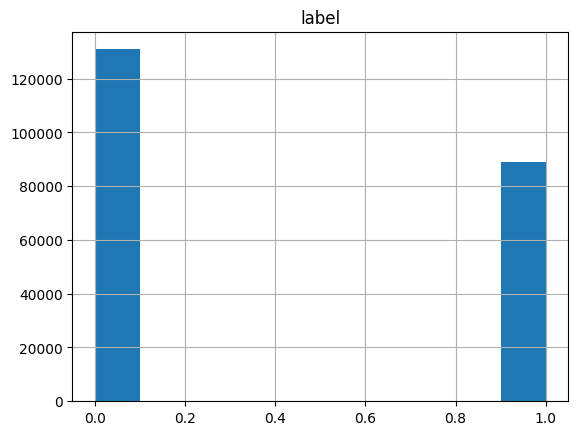

In [4]:
data = pd.read_csv("Data/train_labels.csv")

print(data["label"].value_counts())
hist = data.hist()

In [5]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
data.columns

Index(['id', 'label'], dtype='object')

#### EDA 
The quality of the data is assumed to be high. All of the images were created by professionals and have been sifted through to remove duplicates already. Visual check of datapoints does not reveal any that needed to be removed.

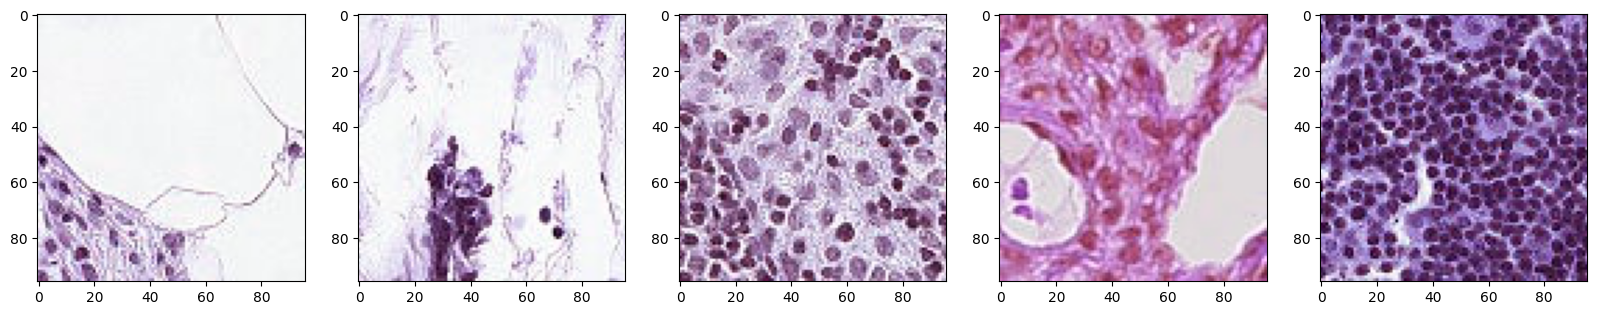

In [7]:
im0 = cv2.imread(f'Data/train/{data["id"][0]}.tif')
num = 5
fig, ax = plt.subplots(1,num, figsize=(20,4))
for i in range(num):
    ax[i].imshow(cv2.imread(f'Data/train/{data["id"][i]}.tif'))

Now let's look at the shape of the data. We can see that the data is 96x96 pixels, with three channels. Let's look athe histogram of RGB values to see if we need to normalize the values.

In [8]:
im0 = cv2.imread(f'Data/train/{data["id"][0]}.tif')
im0.shape

(96, 96, 3)

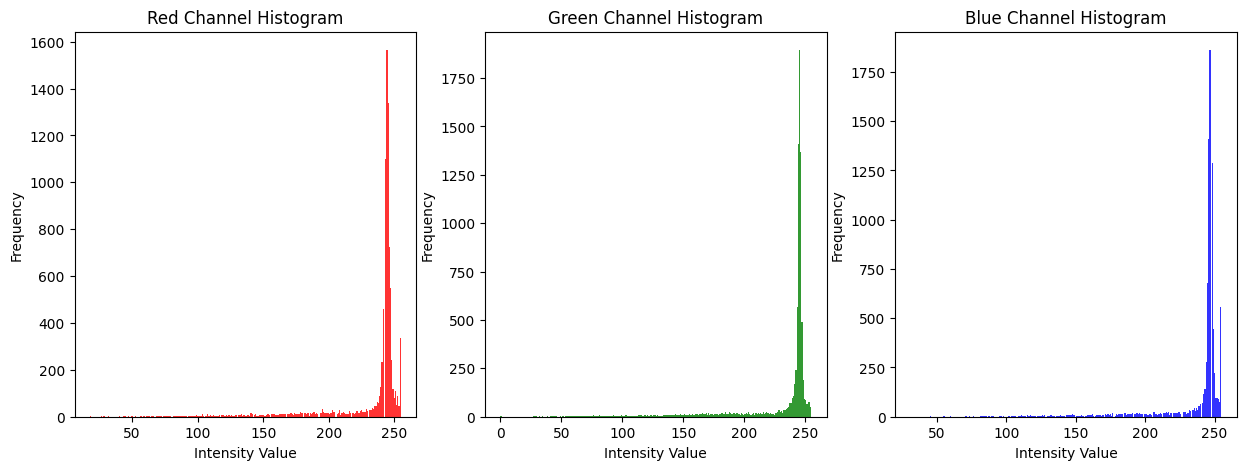

In [9]:
plt.figure(figsize=(15, 5))
colors = ['red', 'green', 'blue']
R, G, B = cv2.split(im0)
channels = [R, G, B]

for i, (channel, color) in enumerate(zip(channels, colors)):
    plt.subplot(1, 3, i+1)
    plt.hist(channel.ravel(), bins=256, color=color, alpha=0.8)
    plt.title(f'{color.capitalize()} Channel Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')

plt.show()

As you can see, the values go from 0 to 255, with this particular image having spikes near 240. We will need to normalize this down to [0,1] before we input them into our model for optimal performance.

Next, we will split the training data into train and validation sets.

In [10]:
data['label'] = data['label'].astype(str)
data["id"] = data["id"].astype(str) + '.tif'

In [11]:
data_train, data_val = train_test_split(data, test_size = 0.2, random_state = 42, stratify =data["label"])
print(data_train.shape)
print(data_val.shape)
print(data_train["label"].value_counts())
print(data_val["label"].value_counts())
print(data_train.columns)
print(data_train.head())

(176020, 2)
(44005, 2)
label
0    104726
1     71294
Name: count, dtype: int64
label
0    26182
1    17823
Name: count, dtype: int64
Index(['id', 'label'], dtype='object')
                                                  id label
198607  cffe7a3ffc48700045fd37f1f448b5a892ff4f2c.tif     0
14684   b5bef3e7d7e8cc81e38fa2288105fc1c130e771a.tif     0
55923   6fe4413a3a982af28a6e78d0f445073c509b4b33.tif     0
215817  d6b4fe580210f5ea61b7c109b5c2e5cc734c3010.tif     0
10219   1b6b051e370ca8468253d2e40f686c66eecb1619.tif     1


Now, we need to get our data into a form that will allow us to use it to train a model. We are going to use an Image Generator. This will allow us to rescale evry photo as it comes in as well as avoid taking up too much memory. It does this by providing photos as they are needed rather than keeping them all in memory all at once.

In [12]:
datagen = ImageDataGenerator(rescale = 1.0/255)

train_gen = datagen.flow_from_dataframe(data_train,
                                        directory = "Data/train/",
                                        target_size = (96,96),
                                        batch_size = 16,
                                        x_col = "id",
                                        y_col = "label",
                                        class_mode = "binary"
                                       )

val_gen = datagen.flow_from_dataframe(data_val,
                                        directory = "Data/train/",
                                        target_size = (96,96),
                                        batch_size = 16,
                                        x_col = "id",
                                        y_col = "label",
                                        class_mode = "binary"
                                       )
                                                                        

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Architecture ###

For our model we are going to start with a simple 2 conv layers followed by max pool, followed by 2 dense layers for the output. The inner laters will use relu and the final output layer will use sigmoid. This is a default that was taken from lecture. This works because it will let the model learn how to pick out knowledge from the convulution laters and then apply that with the final dense layers. After we see how this works, we will try stacking sets of 2 conv and max pool to see how this effects the results, as well as alter the optimization and loss functions.

In [14]:
simple_cnn = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_cnn.compile(
    optimizer=optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = simple_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
)

Epoch 1/20


2025-04-27 21:22:55.082991: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,92,92]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,94,94]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


 6239/11002 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.7589 - loss: 0.5363

2025-04-27 21:23:47.334819: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,64,92,92]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,94,94]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


10996/11002 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7748 - loss: 0.5018

2025-04-27 21:24:27.565137: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,92,92]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,94,94]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-27 21:24:45.422967: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,64,92,92]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,94,94]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

11002/11002 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - accuracy: 0.7748 - loss: 0.5018 - val_accuracy: 0.8375 - val_loss: 0.3774
Epoch 2/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 106s 10ms/step - accuracy: 0.8260 - loss: 0.4042 - val_accuracy: 0.8380 - val_loss: 0.3708
Epoch 3/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 107s 10ms/step - accuracy: 0.8470 - loss: 0.3659 - val_accuracy: 0.8393 - val_loss: 0.3757
Epoch 4/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.8464 - loss: 0.3694 - val_accuracy: 0.8394 - val_loss: 0.3802
Epoch 5/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 112s 10ms/step - accuracy: 0.8435 - loss: 0.3926 - val_accuracy: 0.8186 - val_loss: 0.4178
Epoch 6/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - accuracy: 0.8608 - loss: 0.3499 - val_accuracy: 0.8372 - val_loss: 0.3894
Epoch 7/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.8785 - loss: 0.3123 - val_accuracy: 0.8137 - val_loss: 0.4342
Epoch 8/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accur

The accuracy at this point is already incredibly high. However, the validation accuracy fluctuates around .8 the entire training period. It's even lower at the end of training than it  was at the end. The accuracy, on the other hand, increases rapidly at the beginning and then starts to slowly increase after around epoch 10. For future models we will stop at 10 epochs to prevent over-fitting.

### Additional Analysis ###

Now let's try a slighlty more involved model. We will include an additional max pool between the conv layers.

In [20]:
two_pool_cnn = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

two_pool_cnn.compile(
    optimizer=optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

two_pool_history = two_pool_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
)

Epoch 1/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.7783 - loss: 0.4794 - val_accuracy: 0.8282 - val_loss: 0.4183
Epoch 2/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.8518 - loss: 0.3551 - val_accuracy: 0.8629 - val_loss: 0.3217
Epoch 3/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.8657 - loss: 0.3257 - val_accuracy: 0.8600 - val_loss: 0.3278
Epoch 4/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.8774 - loss: 0.3013 - val_accuracy: 0.8708 - val_loss: 0.3268
Epoch 5/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.8896 - loss: 0.2743 - val_accuracy: 0.8714 - val_loss: 0.3169
Epoch 6/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.8955 - loss: 0.2613 - val_accuracy: 0.8173 - val_loss: 0.4679
Epoch 7/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.8959 - loss: 0.2722 - val_accuracy: 0.8669 - val_loss: 0.3368
Epoch 8/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 

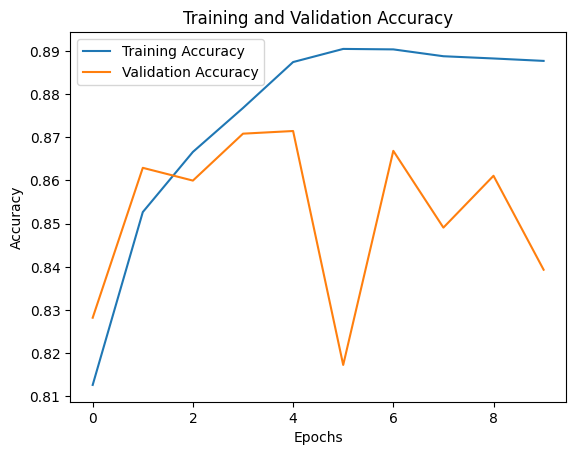

In [21]:
plt.plot(two_pool_history.history['accuracy'], label='Training Accuracy')
plt.plot(two_pool_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

The t4raining accuracy at this point steadily increased until a peak at around epoch 5. However, the validation accuracy stopped increasing around epoch 4. Let's use 4 epochs for the next model.

The next model we will try will introduce batch normalization to the above model. As mentioned in lecture, it can be a great addition as it normalizes everything. This can prevent large swings and make the model more stable.

In [22]:
stable_cnn = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

stable_cnn.compile(
    optimizer=optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

stable_cnn_history = stable_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=4,
)

Epoch 1/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 103s 9ms/step - accuracy: 0.7973 - loss: 0.6923 - val_accuracy: 0.8576 - val_loss: 0.3578
Epoch 2/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 100s 9ms/step - accuracy: 0.8499 - loss: 0.3663 - val_accuracy: 0.8488 - val_loss: 0.3929
Epoch 3/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.8585 - loss: 0.3566 - val_accuracy: 0.7029 - val_loss: 0.7181
Epoch 4/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.8647 - loss: 0.3384 - val_accuracy: 0.7849 - val_loss: 24.7355


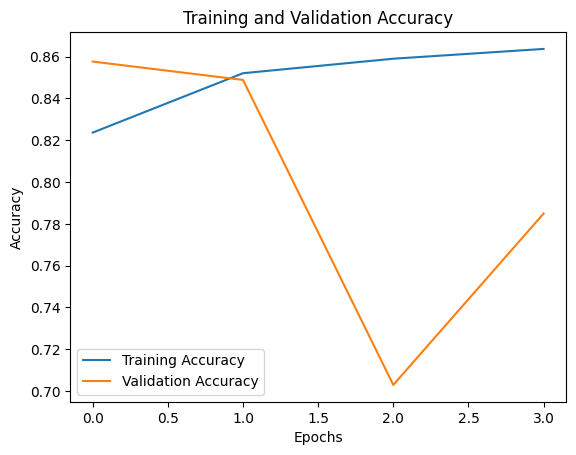

In [23]:
plt.plot(stable_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(stable_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Now that we have tested a few different models, let's see how the most recent, best, one is impacted by significantly lowering the learning rate.

In [24]:
stable_slow_cnn = Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

stable_slow_cnn.compile(
    optimizer=optimizers.RMSprop(learning_rate = 0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

stable_slow_cnn_history = stable_slow_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=4,
)

Epoch 1/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.7792 - loss: 0.4810 - val_accuracy: 0.8297 - val_loss: 0.3884
Epoch 2/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.8369 - loss: 0.3731 - val_accuracy: 0.8369 - val_loss: 0.3765
Epoch 3/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.8646 - loss: 0.3212 - val_accuracy: 0.8375 - val_loss: 0.3824
Epoch 4/4
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 101s 9ms/step - accuracy: 0.8868 - loss: 0.2755 - val_accuracy: 0.8410 - val_loss: 0.3763


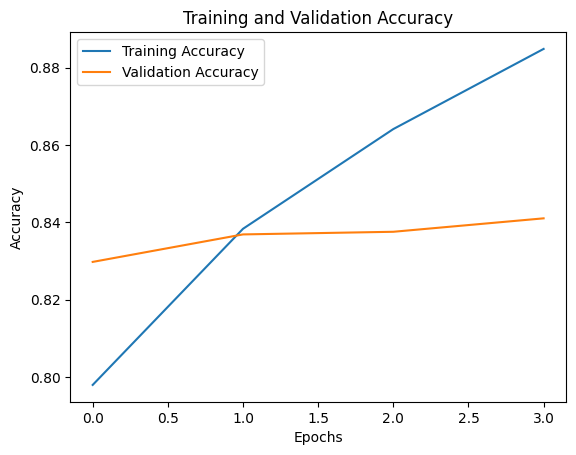

In [26]:
plt.plot(stable_slow_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(stable_slow_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Here, training accuracy steadily improved and did not peak. However, validation accuracy was relatively flat, implying that further training would lead to over-fitting.

### Results ###

In [27]:
two_pool_acc = two_pool_history.history["val_accuracy"][-1]
stable_cnn_acc = stable_cnn_history.history["val_accuracy"][-1]
stable_slow_cnn_acc = stable_slow_cnn_history.history["val_accuracy"][-1]

print(f"Two pool model validation accuracy: {two_pool_acc}")
print(f"Stable model validation accuracy: {stable_cnn_acc}")
print(f"Stable Slow model validation accuracy: {stable_slow_cnn_acc}")

Two pool model validation accuracy: 0.8393364548683167
Stable model validation accuracy: 0.7849107980728149
Stable Slow model validation accuracy: 0.8410180807113647


Overall, we altered the model, learning rate, and number of epochs to get the best model we could.

Now, let's see how the final model performs against the competition.

In [118]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_image_dir = "Data/test/"
data_test = pd.DataFrame({"filename": os.listdir(test_image_dir)})
data_test["filename"] = data_test["filename"].astype(str)
data_test["id"] = "1"
print(data_test.head())



test_gen = test_datagen.flow_from_dataframe(dataframe = data_test,
                                            directory = "./Data/test",
                                            target_size = (96,96),
                                            batch_size = 11,
                                            x_col = "filename",
                                            y_col = "id",
                                            class_mode = "categorical",
                                            shuffle = False
                                           )


                                       filename id
0  b976cfbd905dad4a15b8df99460f5dbd75f045c5.tif  1
1  617a6f15dd1aa8bec6ff73b26dbf40735f9fe2f7.tif  1
2  fd8740fd2d4e0e76ba53b57b1ee1bf3818d1be1f.tif  1
3  32a24610b37a3ac7c25190fb63058f2575a42584.tif  1
4  1ec2a57bad3436e7d395a9f4ba5d59630b95f4eb.tif  1
Found 57458 validated image filenames belonging to 1 classes.


In [119]:
#output = simple_cnn.predict(test_gen)
#output = two_pool_cnn.predict(test_gen)
output = stable_slow_cnn.predict(test_gen)

/home/jkagie/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-27 23:38:46.643394: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[11,32,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,3,96,96]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-27 23:38

5224/5224 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step


In [128]:
predictions = (output > 0.5).astype("int32").flatten()
submission_df = pd.DataFrame({"id": data_test["filename"],
                              "label": predictions
                             })
submission_df["id"] = submission_df["id"].str[:-4]
submission_df.to_csv("submission.csv", index = False)

This provided a public score of 0.7794.

### Conclusion ###
Even a basic CNN can be quite powerful at solving problems like this. In a few minutes (and with access to data) a model can be trained to be far more proficient than a person could likely be in that time. Beyond that, there are ways to make the model even more efficacious depending on the time and data you can funnel into it. Similarly, this shows the strong value of conolutional layers for images.

Lessons learned:
Adding more layers intelligently helped with solving the problem. Adding things like batch normalization or max pool helped the model to have higher accuracy. It also allowed the model to converge faster and need less training time. A lower learning rate made the model accuracy far more consistent and reduced overshooting. It seems that adding the additional stability to the modle without lowering the learning rate lead to overshooting and created a worse model.

Further improvements and ideas:
Adding more layers and further finetuning of the error rate could be helpful in the future. It was not done currently due to the large amount of time it would requirem but as a future weekend project it could be interesting. 